# Bibliothèques nécessaires

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
print(tf.__version__)

2.17.1


## Chargement des données

Ce notebook a été exécuté sur Kaggle pour avoir plus de GPU

In [ ]:
with open('/kaggle/input/dataset/nips_clean.txt', 'r') as file:
  corpus = file.read()

In [ ]:
words = corpus.split()
n_words = len(words)
unique_words = sorted(list(set(words)))
n_unique_words = len(unique_words)
print("Total number of words:", n_words)
print("Total number of unique words: ", n_unique_words)

Total number of words: 783672
Total number of unique words:  15275


## Paramètres

In [ ]:
#configuration
SEQUENCE_LENGTH = 200
MIN_WORD_FREQUENCY = 3
MAX_VOCAB_SIZE = n_unique_words
EMBEDDING_DIM = 256
BATCH_SIZE = 32
DROPOUT_RATE = 0.2
RNN_UNITS = 128
EPOCHS = 300

In [ ]:
# Fréquence des mots
word_count = {}
for word in words:
  word_count[word] = word_count.get(word, 0) + 1
rare_words = set()
for k, v in word_count.items():
  if word_count[k] < MIN_WORD_FREQUENCY:
    rare_words.add(k)
print('Removing words with frequency <', MIN_WORD_FREQUENCY)
print('Total number of rare words: ', len(rare_words))
unique_words = sorted(set(words) - rare_words)
n_unique_words = len(unique_words)
print('Total number of unique words after removing rare words:', n_unique_words)

Removing words with frequency < 3
Total number of rare words:  7291
Total number of unique words after removing rare words: 7984


In [ ]:
MAX_VOCAB_SIZE = n_unique_words

In [ ]:
# Créer des séquences de mots et supprimer les séquences contenant des mots rares
sequences_words = []
n_ignored = 0
ignored_sequences = []
for i in range(0, n_words - SEQUENCE_LENGTH):
	s = ' '.join(words[i:i+SEQUENCE_LENGTH])
	# ajouter seulement des sequences ne contenant pas des mots rares
	if len(set(words[i:i+SEQUENCE_LENGTH]).intersection(rare_words)) == 0:
		sequences_words.append(s)
	else:
		n_ignored = n_ignored + 1
		ignored_sequences.append(s)
print('Total number of sequences without rare words: %d' % len(sequences_words))
print('Total number of sequences with rare words: %d' % len(ignored_sequences))

Total number of sequences without rare words: 139724
Total number of sequences with rare words: 643748


## Tokenisation

In [ ]:
# Tokenization
tokenizer = Tokenizer(filters='', lower=False, oov_token="<OOV>")
tokenizer.fit_on_texts(sequences_words)
word_index = tokenizer.word_index
# convertir les sequences en integers
sequences = tokenizer.texts_to_sequences(sequences_words)
n_sequences = len(sequences)
vocab_size = len(word_index) + 1
print("Number of unique tokens: %d" % len(word_index))
print('Total number of sequences: %d' % n_sequences)

Number of unique tokens: 7196
Total number of sequences: 139724


In [ ]:
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]

In [ ]:
# Génération de données
def generate_arrays(X_all, y_all, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, X.shape[1]), dtype=np.int32)
        y = np.zeros((batch_size, vocab_size), dtype=bool)
        for i in range(batch_size):
            x[i] = X_all[index]
            y[i] = to_categorical(y_all[index], num_classes = vocab_size)

            index = index + 1
            if index == len(X_all):
               index = 0
        yield (x, y)

In [ ]:
# training set et testing set
def shuffle_train_test_split(X_all, y_all, shuffle=True, test_percent=20, random_state=10):

    if shuffle:
      X_all_shuffled = []
      y_all_shuffled = []
      for i in np.random.RandomState(seed=random_state).permutation(len(X_all)):
          X_all_shuffled.append(X_all[i])
          y_all_shuffled.append(y_all[i])
    else:
      X_all_shuffled = X_all
      y_all_shuffled = y_all

    split_index = int(len(X_all) * (1.-(test_percent/100.)))
    X_train, X_test = X_all_shuffled[:split_index], X_all_shuffled[split_index:]
    y_train, y_test = y_all_shuffled[:split_index], y_all_shuffled[split_index:]

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = shuffle_train_test_split(X, y, test_percent=0)

## Modèle

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH-1))
model.add(Bidirectional(LSTM(units=RNN_UNITS)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(units=vocab_size, activation='softmax'))
model.build(input_shape=(None, SEQUENCE_LENGTH-1))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 199, 256)            │       1,842,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7197)                │       1,849,629 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,086,301 (15.59 MB)

 Trainable params: 4,086,301 (15.59 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks_list = [early_stopping]

## Entrainement du modèle

In [ ]:
model.fit(generate_arrays(X_train, y_train, BATCH_SIZE),
                    steps_per_epoch = (len(X) // BATCH_SIZE) + 1,
                    epochs = EPOCHS,
                    callbacks = callbacks_list)

Epoch 1/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.1089 - loss: 6.2192
Epoch 2/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.1988 - loss: 5.1232
Epoch 3/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.2270 - loss: 4.6894
Epoch 4/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.2515 - loss: 4.3124
Epoch 5/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.2766 - loss: 3.9645
Epoch 6/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.3058 - loss: 3.6373
Epoch 7/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.3375 - loss: 3.3491
Epoch 8/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 90s 21ms/step - accuracy: 0.3720 - loss: 3.0708
Epoch 9/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.4046 - loss: 2.8324
Epoch 10/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.4383 - loss: 2.6234
Epoch 11/300
4367/4367 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.4629 - loss: 2.45

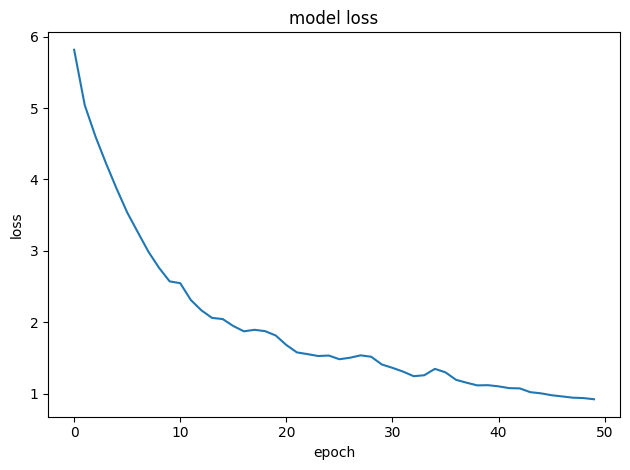

In [ ]:
# Plot loss curves
fig = plt.figure()
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()

# Sauvegarde

In [ ]:
from pickle import dump
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [ ]:
# enregistrer les séquences dans un fichier
data = '\n'.join(sequences_words)
with open("sequences_words.txt", 'w') as file:
  file.write(data)

In [ ]:
# enregistrer le modèle
model.save('model.h5')